In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x


def get_params(model):
    return torch.cat([param.data.view(-1) for param in model.parameters()])

def set_params(model, params):
    param_shapes = [param.data.shape for param in model.parameters()]
    param_sizes = [param.numel() for param in model.parameters()]

    index = 0
    for i, param in enumerate(model.parameters()):
        size = param_sizes[i]
        param_slice = params[index:index + size].view(param_shapes[i])
        param.data.copy_(param_slice)
        index += size

def split(train_dataset, alpha, num_clients):
    train_size = len(train_dataset)
    subsets = [[] for _ in range(10)]
    final_dataset = [[] for _ in range(num_clients)]
    final_size = train_size // num_clients
    for i in range(train_size):
        image, label = train_dataset[i]
        subsets[label].append((image, label))

    w0 = torch.tensor([1/10 for _ in range(10)])
    dir = dist.Dirichlet(w0*alpha)
    for i in range(num_clients):
        w = dir.sample()
        samples = torch.multinomial(w, final_size, replacement=True)
        for j in range(final_size):
            a = torch.randint(0, len(subsets[samples[j]]), (1,)).item()
            final_dataset[i].append(subsets[samples[j]][a])


    datasets_tensor = []
    for i in range(num_clients):
        images = torch.stack([x[0] for x in final_dataset[i]])
        labels = torch.tensor([x[1] for x in final_dataset[i]], dtype=torch.int64)
        datasets_tensor.append(TensorDataset(images, labels))


    return datasets_tensor


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

test_dataset = DataLoader(test_dataset, batch_size=64, shuffle=False)

def client_train(model, train_loader, optimizer, criterion, epochs=1, noise_std=0.01):
    model.train()
    for _ in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            for param in model.parameters():
                noise = torch.randn_like(param.data) * noise_std
                param.data.add_(noise)

    

num_clients = 5 
T = 60
num_epochs = 1
theta = 0.5
gamma = 100 
noise_std = 0.01
alpha = 0.1

train_datasets = split(train_dataset, alpha, num_clients)


batch_size = 128
learning_rate = 0.01

In [ ]:
def asysgd(gamma):
    client_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in train_datasets]

    global_model = MLP()
    criterion = nn.CrossEntropyLoss()
    client_models = [MLP() for _ in range(num_clients)]
    client_optimizers = [optim.SGD(model.parameters(), lr=learning_rate) for model in client_models]

    client_data_sizes = [len(loader.dataset) for loader in client_loaders]

    params1 = get_params(global_model)
    mm = [torch.zeros_like(params1) for _ in range(num_clients)]

    concentration = torch.tensor([2.0])
    rate = torch.tensor([0.8])
    gamma_dict = dist.Gamma(concentration, rate)
    tau_mean = gamma_dict.sample((num_clients,))
    print(tau_mean)
    tau = torch.zeros((num_clients,3))
    for i in range(num_clients):
        tau[i,2] = torch.max(torch.tensor([1,tau_mean[i].item()+0.1*torch.randn(1).item()]))
    tau[:,0] = -1
    print(tau)
    theta = 0.0
    global_params = [torch.zeros_like(params1) for _ in range(T)]
    accuracy = []
    for t in range(T):
        print(t)
        if(t%5==0):
            gamma = gamma/2
    
        for i in range(num_clients):
            if t>=tau[i][2]:
                tau[i][0] = tau[i][1]
                tau[i][1] = tau[i][2]
                a = tau[i][2]
                b = int(a.item())+1
                c = a + max([0,tau_mean[i].item()+0.1*torch.randn(1).item()]) 
                if c<b:
                    tau[i][2] = b
                else:
                    tau[i][2] = c
            tau1 = int(tau[i][0].item())+1
            set_params(client_models[i], global_params[tau1])


        for i, client_loader in enumerate(client_loaders):
            params1 = get_params(client_models[i])
            client_train(client_models[i], client_loader, client_optimizers[i], criterion, epochs=num_epochs, noise_std=noise_std)

            params2 = get_params(client_models[i])
            mm[i] = theta*mm[i]+(1-theta)*(params1-params2)/(learning_rate * num_epochs)
  
        global_params[t] = get_params(global_model)
        sum_tensor = torch.stack([mm[i] for i in range(num_clients)], 0).sum(0)
        global_params[t] -= gamma * sum_tensor/num_clients

        set_params(global_model,global_params[t])

        if (t + 1) % 2 == 0:
            correct = 0
            total = 0
            with torch.no_grad():
                for data in test_dataset:
                    images, labels = data
                    outputs = global_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    loss = criterion(outputs, labels)
                accuracy.append(100 * correct / total)
            print('Step {}: loss = {}, Accuracy of the network on the 10000 test images: {} %'.format(t + 1, loss, 100 * correct / total)) 

    return accuracy

In [ ]:
def normed_asysgd(gamma):
    client_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in train_datasets]

    global_model = MLP()
    criterion = nn.CrossEntropyLoss()
    client_models = [MLP() for _ in range(num_clients)]
    client_optimizers = [optim.SGD(model.parameters(), lr=learning_rate) for model in client_models]

    client_data_sizes = [len(loader.dataset) for loader in client_loaders]

    params1 = get_params(global_model)
    mm = [torch.zeros_like(params1) for _ in range(num_clients)]

    concentration = torch.tensor([2.0])
    rate = torch.tensor([0.8])
    gamma_dict = dist.Gamma(concentration, rate)
    tau_mean = gamma_dict.sample((num_clients,))
    print(tau_mean)
    tau = torch.zeros((num_clients,3))
    for i in range(num_clients):
        tau[i,2] = torch.max(torch.tensor([1,tau_mean[i].item()+0.1*torch.randn(1).item()]))
    tau[:,0] = -1
    print(tau)

    global_params = [torch.zeros_like(params1) for _ in range(T)]
    accuracy = []
    for t in range(T):
        print(t)
        if(t%5==0):
            gamma = gamma/2
    
        for i in range(num_clients):
            if t>=tau[i][2]:
                tau[i][0] = tau[i][1]
                tau[i][1] = tau[i][2]
                a = tau[i][2]
                b = int(a.item())+1
                c = a + max([0,tau_mean[i].item()+0.1*torch.randn(1).item()]) 
                if c<b:
                    tau[i][2] = b
                else:
                    tau[i][2] = c
            tau1 = int(tau[i][0].item())+1
            set_params(client_models[i], global_params[tau1])


        for i, client_loader in enumerate(client_loaders):
            params1 = get_params(client_models[i])
            client_train(client_models[i], client_loader, client_optimizers[i], criterion, epochs=num_epochs, noise_std=noise_std)
            params2 = get_params(client_models[i])
            mm[i] = theta*mm[i]+(1-theta)*(params1-params2)/(learning_rate * num_epochs)
  
        global_params[t] = get_params(global_model)
        sum_tensor = torch.stack([mm[i] for i in range(num_clients)], 0).sum(0)
        global_params[t] -= gamma * sum_tensor/torch.norm(sum_tensor, p = 2)

        set_params(global_model,global_params[t])

        if (t + 1) % 2 == 0:
            correct = 0
            total = 0
            with torch.no_grad():
                for data in test_dataset:
                    images, labels = data
                    outputs = global_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    loss = criterion(outputs, labels)
                accuracy.append(100 * correct / total)
            print('Step {}: loss = {}, Accuracy of the network on the 10000 test images: {} %'.format(t + 1, loss, 100 * correct / total)) 

    return accuracy

In [ ]:
gamma = 500
accuracy_asysgd = asysgd(gamma)
accuracy_normed_asysgd = normed_asysgd(gamma)
gammas = [200,100,50,20,10,5,2,1,0.5,0.2,0.1,0.05,0.02,0.01,0.005,0.002,0.001]
for gamma in gammas:
    print(gamma)
    accuracy_asysgd_new = asysgd(gamma)
    accuracy_normed_asysgd_new = normed_asysgd(gamma)
    if accuracy_asysgd_new[-1] >= accuracy_asysgd[-1]:
        accuracy_asysgd = accuracy_asysgd_new
    if accuracy_normed_asysgd_new[-1] >= accuracy_normed_asysgd[-1]:
        accuracy_normed_asysgd = accuracy_normed_asysgd_new

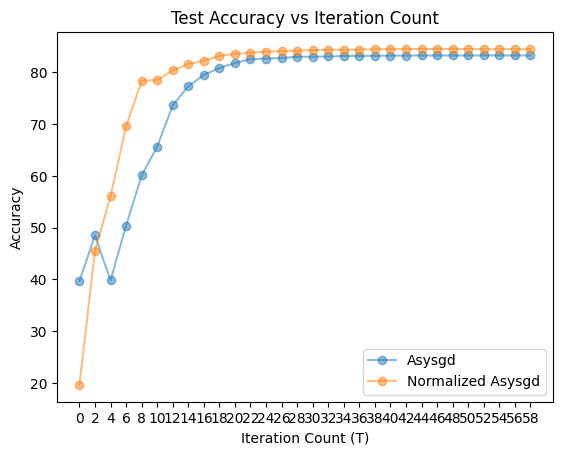

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


T = np.arange(0, 60, 2)

plt.plot(T, accuracy_asysgd, '-o', label='Asgd', alpha=0.5)
plt.plot(T, accuracy_normed_asysgd, '-o', label='Normalized Asysgd', alpha=0.5)

plt.xticks(T)

plt.title('Test Accuracy vs Iteration Count')
plt.xlabel('Iteration Count (T)')
plt.ylabel('Accuracy')

plt.legend()

plt.show()